In [2]:
import functools

import jax
import jax.experimental.pallas as pl
from jax.experimental.pallas import tpu as pltpu
import jax.numpy as jnp
from jax import random
import numpy as np

In [3]:
def matmul_kernel(x_ref, y_ref, z_ref, acc_ref, *, nsteps):
  """Steps of a matrix contraction comprising `nsteps` block matmuls."""

  # Initialize `acc_ref` on VMEM.
  @pl.when(pl.program_id(2) == 0)
  def _(): acc_ref[...] = jnp.zeros_like(acc_ref)

  # Load the inputs into VREG, perform matmul, then store the results in VMEM.
  acc_ref[...] += jnp.dot(
      x_ref[...], y_ref[...], preferred_element_type=jnp.float32
  )

  # Cast `acc_ref` to the output dtype and write to VMEM.
  @pl.when(pl.program_id(2) == nsteps - 1)
  def _(): z_ref[...] = acc_ref[...].astype(z_ref.dtype)


@functools.partial(jax.jit, static_argnames=['bm', 'bk', 'bn'])
def matmul(
    x: jax.Array,
    y: jax.Array,
    *,
    bm: int = 128,
    bk: int = 128,
    bn: int = 128,
):
  m, k = x.shape
  _, n = y.shape
  return pl.pallas_call(
      functools.partial(matmul_kernel, nsteps=k // bk),
      grid_spec=pltpu.PrefetchScalarGridSpec(
        num_scalar_prefetch=0,
        in_specs=[
            pl.BlockSpec((bm, bk), lambda i, j, k: (i, k)),
            pl.BlockSpec((bk, bn), lambda i, j, k: (k, j)),
        ],
        out_specs=pl.BlockSpec((bm, bn), lambda i, j, k: (i, j)),
        scratch_shapes=[pltpu.VMEM((bm, bn), jnp.float32)],  # type: ignore
        grid=(m // bm, n // bn, k // bk),
      ),
      out_shape=jax.ShapeDtypeStruct((m, n), x.dtype),
      compiler_params=pltpu.TPUCompilerParams(
          dimension_semantics=("parallel", "parallel", "parallel")),
  )(x, y)

In [4]:
m, k, n = 4096, 4096, 4096
k1, k2 = random.split(random.key(0), 2)
x = random.normal(k1, (m, k), dtype=jnp.bfloat16)
y = random.normal(k2, (k, n), dtype=jnp.bfloat16)
np.testing.assert_array_equal(x @ y, matmul(x, y))

Check the jaxpr of the matmul kernel

In [5]:
jax.make_jaxpr(matmul)(jax.ShapeDtypeStruct((4096, 4096), jnp.bfloat16), jax.ShapeDtypeStruct((4096, 4096), jnp.bfloat16))

{ lambda ; a:bf16[4096,4096] b:bf16[4096,4096]. let
    c:bf16[4096,4096] = pjit[
      name=matmul
      jaxpr={ lambda ; a:bf16[4096,4096] b:bf16[4096,4096]. let
          c:bf16[4096,4096] = pallas_call[
            backend=None
            compiler_params={'mosaic_tpu': TPUCompilerParams(dimension_semantics=('parallel', 'parallel', 'parallel'), allow_input_fusion=None, vmem_limit_bytes=None, collective_id=None, has_side_effects=False, flags=None, internal_scratch_in_bytes=None, serialization_format=1, kernel_type=<KernelType.TC: 0>, disable_bounds_checks=False)}
            cost_estimate=None
            debug=False
            grid_mapping=GridMapping(grid=(32, 32, 32), grid_names=None, block_mappings=(BlockMapping(block_shape=(Blocked(block_size=128), Blocked(block_size=128)), transformed_block_aval=MemRef<None>{bfloat16[128,128]}, index_map_jaxpr={ lambda ; a:i32[] b:i32[] c:i32[]. let  in (a, c) }, array_shape_dtype=ShapeDtypeStruct(shape=(4096, 4096), dtype=bfloat16), origin='

In [6]:
import timeit

v5e_flops = 197e12
v5e_membw = 819e9
v5e_op_intensity = v5e_flops / v5e_membw  # ~240.5

def matmul_flops(m: int, k: int, n: int):
  return 2 * m * k * n

def matmul_membw(m: int, k: int, n: int, dtype: jnp.dtype):
  return (m * k + k * n + m * n) * np.dtype(dtype).itemsize

def benchmark(f, min_time: float = 30.0):
  def run(*args, **kwargs):
    # Compile function first
    jax.block_until_ready(f(*args, **kwargs))
    # Time function until we exceed min_time
    trials = 0
    total_time = 0.0
    start = timeit.default_timer()
    
    while total_time < min_time:
      jax.block_until_ready(f(*args, **kwargs))
      trials += 1
      total_time = timeit.default_timer() - start
      
    time_per_iter = total_time / trials
    return time_per_iter
  return run

def analyze_matmul(m: int, k: int, n: int, dtype: np.dtype,
                   mm_func):
  x = jnp.ones((m, k), dtype=dtype)
  y = jnp.ones((k, n), dtype=dtype)
  time = benchmark(mm_func)(x, y)
  print(f"----- {m} x {k} x {n} -----")
  print("Matmul time: ", time)
  mm_flops = matmul_flops(m, k, n) / time
  print("Matmul FLOP/s: ", mm_flops)
  print(f"FLOP/s utilization: {mm_flops / v5e_flops * 100:.4f}%")
  print()
  return mm_flops

print("================bm=128, bk=128, bn=128===================")
mm = functools.partial(matmul, bm=128, bk=128, bn=128)
analyze_matmul(1024, 1024, 1024, jnp.bfloat16, mm)
analyze_matmul(4096, 4096, 4096, jnp.bfloat16, mm)
analyze_matmul(8192, 8192, 8192, jnp.bfloat16, mm)

print("================bm=512, bk=512, bn=512===================")
mm = functools.partial(matmul, bm=512, bk=512, bn=512)
analyze_matmul(1024, 1024, 1024, jnp.bfloat16, mm)
analyze_matmul(4096, 4096, 4096, jnp.bfloat16, mm)
analyze_matmul(8192, 8192, 8192, jnp.bfloat16, mm)

print("================bm=512, bk=1024, bn=1024===================")
mm = functools.partial(matmul, bm=512, bk=1024, bn=1024)
analyze_matmul(1024, 1024, 1024, jnp.bfloat16, mm)
analyze_matmul(4096, 4096, 4096, jnp.bfloat16, mm)
analyze_matmul(8192, 8192, 8192, jnp.bfloat16, mm)

================bm=128, bk=128, bn=128===================
----- 1024 x 1024 x 1024 -----
Matmul time:  0.0003087257181756042
Matmul FLOP/s:  6955959680620.143
FLOP/s utilization: 3.5309%

----- 4096 x 4096 x 4096 -----
Matmul time:  0.01146363855485851
Matmul FLOP/s:  11989121326034.021
FLOP/s utilization: 6.0858%

----- 8192 x 8192 x 8192 -----
Matmul time:  0.09124659129494864
Matmul FLOP/s:  12049892628009.53
FLOP/s utilization: 6.1167%

================bm=512, bk=512, bn=512===================
----- 1024 x 1024 x 1024 -----
Matmul time:  0.00014542963515632175
Matmul FLOP/s:  14766478962088.285
FLOP/s utilization: 7.4957%

----- 4096 x 4096 x 4096 -----
Matmul time:  0.0010975489254442309
Matmul FLOP/s:  125223532441956.38
FLOP/s utilization: 63.5652%

----- 8192 x 8192 x 8192 -----
Matmul time:  0.0074524620037351936
Matmul FLOP/s:  147536696896263.53
FLOP/s utilization: 74.8917%

================bm=512, bk=1024, bn=1024===================
----- 1024 x 1024 x 1024 -----
Matmul tim

180883980208195.0

Visualize the performance

In [7]:
block_sizes = [128, 256, 512]
mm_tflops = [analyze_matmul(32768, 65536, 32768, jnp.bfloat16, functools.partial(matmul, bm=s, bk=s, bn=s)) / 1e12 for s in block_sizes]

----- 32768 x 65536 x 32768 -----
Matmul time:  11.53379741233463
Matmul FLOP/s:  12202181408598.23
FLOP/s utilization: 6.1940%

----- 32768 x 65536 x 32768 -----
Matmul time:  2.367544648380807
Matmul FLOP/s:  59444491765585.125
FLOP/s utilization: 30.1749%

----- 32768 x 65536 x 32768 -----
Matmul time:  0.9447667049971642
Matmul FLOP/s:  148965334628034.38
FLOP/s utilization: 75.6169%



In [8]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

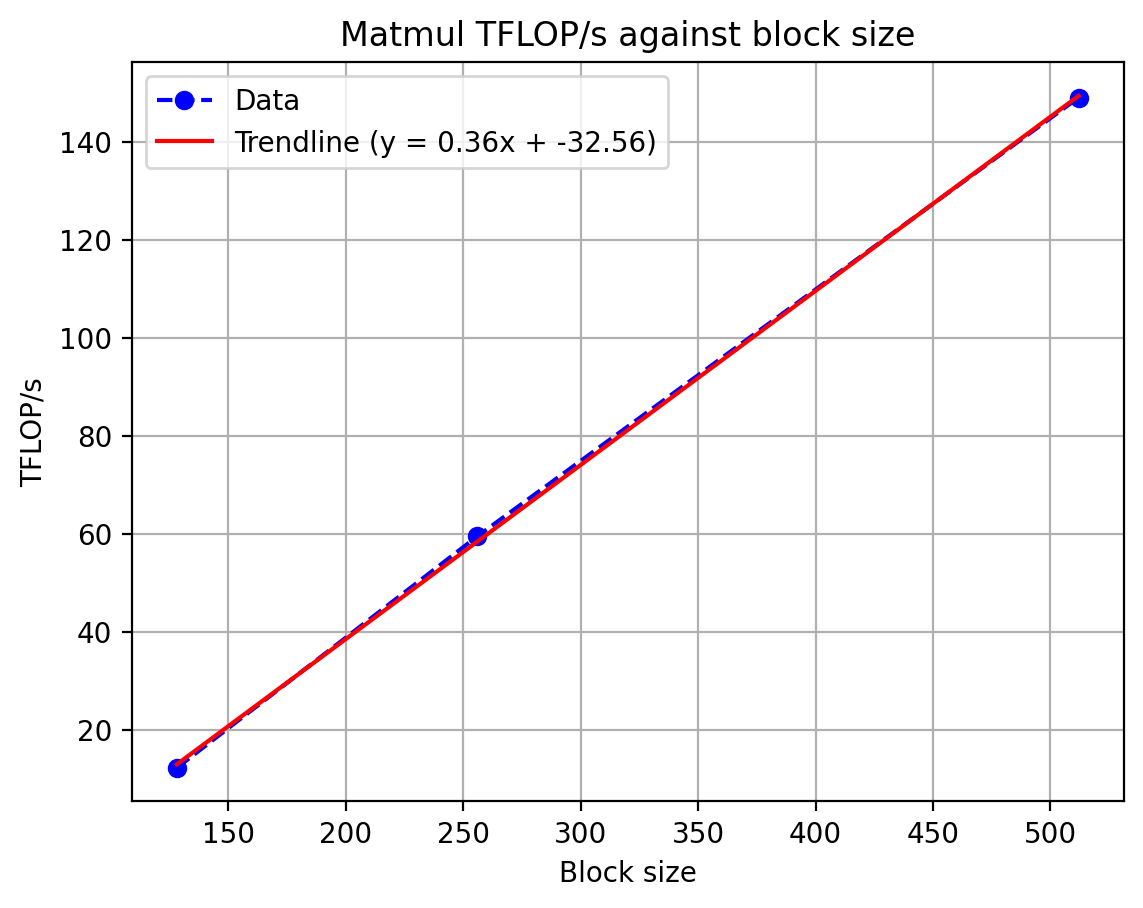

In [9]:
import numpy as np

# Calculate trendline
coeffs = np.polyfit(block_sizes, mm_tflops, 1)
fitted = np.poly1d(coeffs)

plt.plot(block_sizes, mm_tflops, 'bo--', label='Data')
plt.plot(block_sizes, fitted(block_sizes), 'r-', label=f'Trendline (y = {coeffs[0]:.2f}x + {coeffs[1]:.2f})')
plt.title('Matmul TFLOP/s against block size')
plt.ylabel('TFLOP/s')
plt.xlabel('Block size')
plt.legend()
plt.grid(True)
plt.show()

## Why does the matmul FLOP/s increase linearly with respect to block size?

This is indicative of a memory bandwidth-bound regime. In a roofline model, the
following applies when bandwidth-bound:

```
FLOP/s = bandwidth * arithmetic_intensity
```

Let's compute the arithmetic intensity and bandwidth.

In [10]:
# Assumption: HBM bandwidth is the limiting factor.
# Pallas only supports double-buffered pipelines on the TPU.
# Therefore, we further assume that one memory operation overlaps with one compute operation.
# The duration of each pipeline iteration will be bounded by the memory transfer time.

def block_size_to_arithmetic_intensity(block_size):
  # 2 bytes per element (bf16), 2 inputs, 1 output
  bytes_transferred = block_size * block_size * (2 + 1) * 2
  flops = 2 * block_size * block_size * block_size + (block_size * block_size)
  return flops / bytes_transferred

arithmetic_intensities = [block_size_to_arithmetic_intensity(s) for s in block_sizes]
print(arithmetic_intensities)

[42.833333333333336, 85.5, 170.83333333333334]


![memory_bound](https://docs.jax.dev/en/latest/_images/pipelining_bandwidth_bound.svg)

In [11]:
weights = np.ones_like([0] + arithmetic_intensities)
weights[0] = 1e5
coeffs = np.polyfit([0] + arithmetic_intensities, [0] + mm_tflops, 1, w=weights)
tflops_per_ai = coeffs[0]
print(f"Estimated memory bandwidth: {tflops_per_ai} TB/s. Hardware memory bandwidth: {v5e_membw / 1e12} TB/s")

Estimated memory bandwidth: 0.8101810984093003 TB/s. Hardware memory bandwidth: 0.819 TB/s


Increasing the block size will increase the arithmetic intensity of computing a
single intermediate block, which is what the kernel does.

How does that change the overall arithmetic intensity? Let's compute the overall
number of bytes transferred (the FLOPs should be the same).

In [14]:
from dataclasses import dataclass

@dataclass
class Analysis:
  flops: float
  bytes_transferred: float
  arithmetic_intensity: float

def block_size_to_overall_arithmetic_intensity(block_size):
  n = m = k = 32768
  num_iterations = (n // block_size) * (m // block_size) * (k // block_size)
  bytes_transferred_per_iteration = block_size * block_size * (2 + 1) * 2
  bytes_transferred = bytes_transferred_per_iteration * num_iterations
  flops_per_iteration = 2 * block_size * block_size * block_size + (block_size * block_size)
  flops = flops_per_iteration * num_iterations
  arithmetic_intensity = flops / bytes_transferred
  return Analysis(
    flops=flops,
    bytes_transferred=bytes_transferred,
    arithmetic_intensity=arithmetic_intensity,
  )


analysis = [block_size_to_overall_arithmetic_intensity(s) for s in block_sizes]
print(analysis)
for (an, ai) in zip(analysis, arithmetic_intensities):
  assert an.arithmetic_intensity == ai

[Analysis(flops=70643622084608, bytes_transferred=1649267441664, arithmetic_intensity=42.833333333333336), Analysis(flops=70506183131136, bytes_transferred=824633720832, arithmetic_intensity=85.5), Analysis(flops=70437463654400, bytes_transferred=412316860416, arithmetic_intensity=170.83333333333334)]


Actually, there is no need to compute the overall arithmetic intensity. The AI
of each pipeline iteration will be the same as the overall workload AI, which
simply comprises $\frac{n m k}{B ^ 3}$ pipeline iterations.

Let's look at the FLOPs and bytes transferred over the entire matmul.

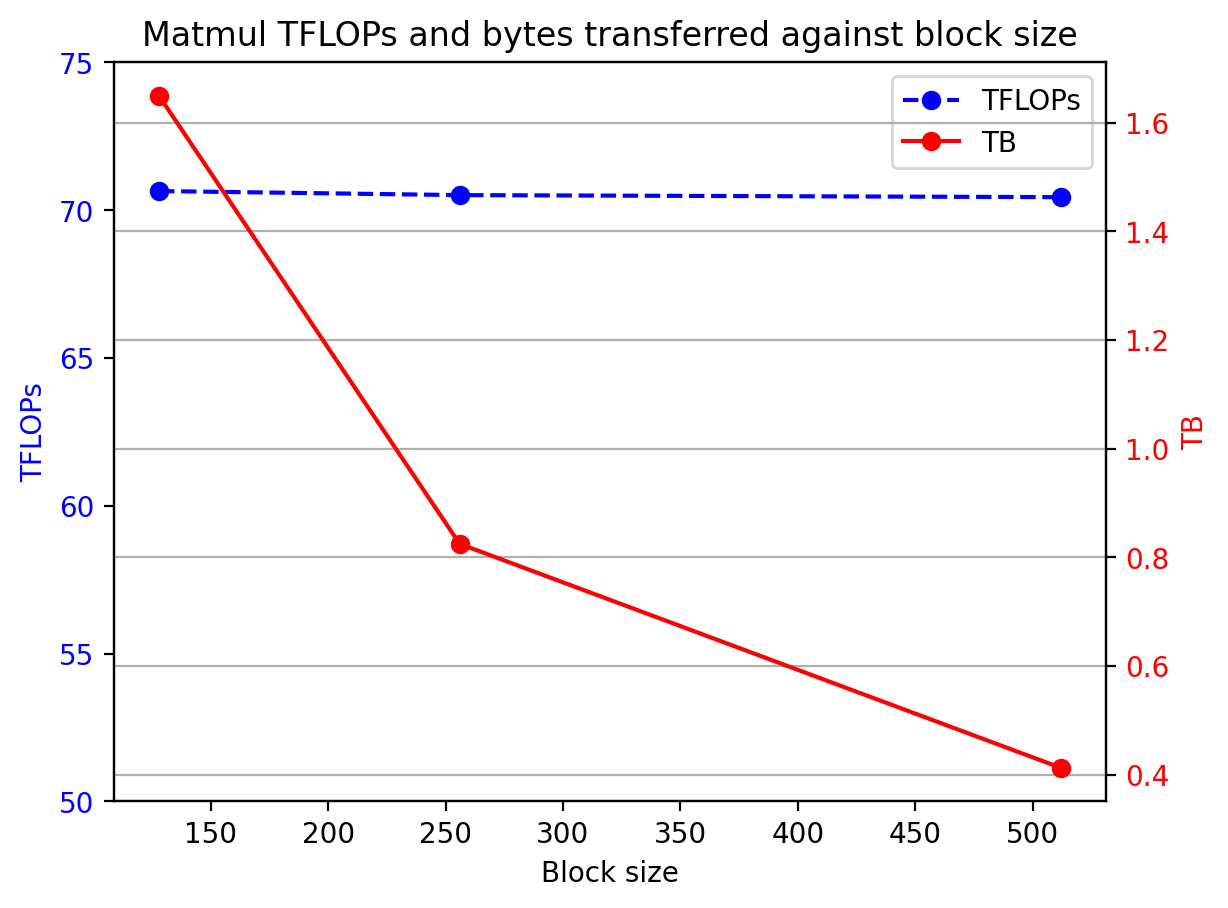

In [31]:
# Create figure and primary axis
fig, ax1 = plt.subplots()

# Plot TFLOPs on left y-axis
ax1.set_xlabel('Block size')
ax1.set_ylabel('TFLOPs', color='blue')
line1 = ax1.plot(block_sizes, [a.flops / 1e12 for a in analysis], 'bo--', label='TFLOPs')
ax1.set_ylim(50, 75)
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis and plot TB
ax2 = ax1.twinx()
ax2.set_ylabel('TB', color='red')
line2 = ax2.plot(block_sizes, [a.bytes_transferred / 1e12 for a in analysis], 'ro-', label='TB')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')  # type: ignore

plt.title('Matmul TFLOPs and bytes transferred against block size')
plt.grid(True)
plt.show()

The FLOPs stay basically the same while there's a significant decrease in bytes
transferred as we increase the block size. That's because the number of
iterations is $O(B^{-3})$ whereas the bytes transferred in one iteration is only
$O(B^2)$.

Another way to think about this is that block matrix multiplication never
redundantly load a block from the source operands when computing a block. In the
limit, if all three matrices fits in VMEM, then we'll never have any redunant
loads overall.

The generalization of this approach is the
[recursive block matrix multiplication algorithm](https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm#Cache_behavior_2),
which is cache-optimal and cache-oblivious.